In [1]:
import pandas as pd

In [2]:
data = pd.read_csv('train_clean_new_columns.csv')

In [3]:
from sklearn.decomposition import PCA

In [9]:
#Insert SKLearn Metrics

from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import f1_score, make_scorer
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import MinMaxScaler
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer

In [5]:
import numpy as np

In [6]:
#Create Indicators

train_labels = np.array(list(data[data['target'].notnull()]['target'].astype(np.uint8)))

In [7]:
#Create Train Set, drop strings / labels

train_set = data[data['target'].notnull()].drop(columns = ['household_id', 'id', 'target'])

In [10]:
#Scale Data

features = list(train_set.columns)

pipeline = Pipeline([('imputer', SimpleImputer(strategy = 'median')), 
                      ('scaler', MinMaxScaler())])

train_set = pipeline.fit_transform(train_set)

In [11]:
#Create F1 Score

scorer = make_scorer(f1_score, greater_is_better=True, average = 'macro')

In [12]:
#Import Models SK_Learn

from sklearn.svm import LinearSVC
from sklearn.naive_bayes import GaussianNB
from sklearn.neural_network import MLPClassifier
from sklearn.linear_model import LogisticRegressionCV, RidgeClassifierCV
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.neighbors import KNeighborsClassifier

#Source: https://github.com/WillKoehrsen/data-science-for-good/blob/master/costa-rican-poverty/A%20Complete%20Walkthrough.ipynb

In [13]:
#Balance Data - Install

from collections import Counter

from imblearn.over_sampling import SMOTE

In [14]:
#Balance Data, and verify our new tables are balanced

print('Original dataset shape %s' % Counter(np.ravel(train_labels)))

sm = SMOTE(random_state=42)

X_res, y_res = sm.fit_resample(train_set, np.ravel(train_labels))

print('Resampled dataset shape %s' % Counter(y_res))

Original dataset shape Counter({4: 1954, 2: 442, 3: 355, 1: 222})
Resampled dataset shape Counter({4: 1954, 2: 1954, 3: 1954, 1: 1954})


In [15]:
#Function to loop through model types

model_results_balanced = pd.DataFrame(columns = ['model', 'cv_mean', 'cv_std'])

def cv_model(train, train_labels, model, name, model_results_balanced=None):
    """Perform 10 fold cross validation of a model"""

    cv_scores = cross_val_score(model, train, train_labels, cv = 10, scoring=scorer, n_jobs = -1)
    print(f'10 Fold CV Score: {round(cv_scores.mean(), 5)} with std: {round(cv_scores.std(), 5)}')
    
    if model_results_balanced is not None:
        model_results_balanced = model_results_balanced.append(pd.DataFrame({'model': name, 
                                                           'cv_mean': cv_scores.mean(), 
                                                            'cv_std': cv_scores.std()},
                                                           index = [0]),
                                             ignore_index = True)

        return model_results_balanced

In [16]:
#balanced Linear Support Vector Classiciation

model_results_balanced = cv_model(X_res, y_res, LinearSVC(), 
                         'LSVC', model_results_balanced)

10 Fold CV Score: 0.52966 with std: 0.02111


In [17]:
#balanced Gaussian Naive Bayes

model_results_balanced = cv_model(X_res, y_res, 
                         GaussianNB(), 'GNB', model_results_balanced)

10 Fold CV Score: 0.20135 with std: 0.01433


In [18]:
#balanced Neural Network Multi Layer Perceptor

model_results_balanced = cv_model(X_res, y_res, 
                         MLPClassifier(hidden_layer_sizes=(32, 64, 128, 64, 32)),
                         'MLP', model_results_balanced)

10 Fold CV Score: 0.89855 with std: 0.02729


In [19]:
#balanced LDA

model_results_balanced = cv_model(X_res, y_res, 
                          LinearDiscriminantAnalysis(), 
                          'LDA', model_results_balanced)

10 Fold CV Score: 0.53967 with std: 0.02097


In [20]:
#balanced Ridge

model_results_balanced = cv_model(X_res, y_res, 
                         RidgeClassifierCV(), 'RIDGE', model_results_balanced)

10 Fold CV Score: 0.52571 with std: 0.01838


In [21]:
#balanced K Nearest Neighbors

for n in [5, 10, 20]:
    print(f'\nKNN with {n} neighbors\n')
    model_results_balanced = cv_model(X_res, y_res, 
                             KNeighborsClassifier(n_neighbors = n),
                             f'knn-{n}', model_results_balanced)


KNN with 5 neighbors

10 Fold CV Score: 0.81774 with std: 0.01933

KNN with 10 neighbors

10 Fold CV Score: 0.75978 with std: 0.02433

KNN with 20 neighbors

10 Fold CV Score: 0.67379 with std: 0.04323


In [22]:
#balanced Random Forest

model_results_balanced = cv_model(X_res, y_res,
                          RandomForestClassifier(100, random_state=10),
                              'RF', model_results_balanced)

10 Fold CV Score: 0.91246 with std: 0.07424


In [24]:
#import visulization programs

import matplotlib.pyplot as plt
import seaborn as sns

In [28]:
#move row name to columns

model_results_balanced.index.name = 'model'
model_results_balanced.reset_index(inplace=True)

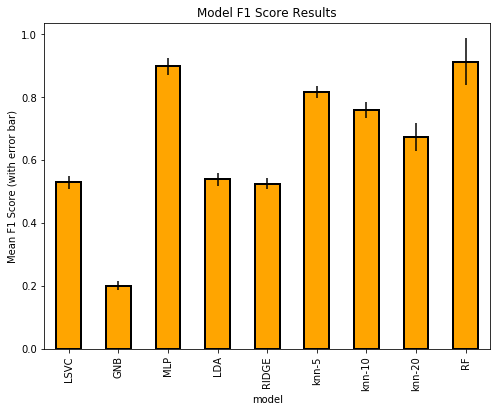

In [29]:
#Create F-1 Score Bar Chart

model_results_balanced.set_index('model', inplace = True)
model_results_balanced['cv_mean'].plot.bar(color = 'orange', figsize = (8, 6),
                                  yerr = list(model_results_balanced['cv_std']),
                                  edgecolor = 'k', linewidth = 2)
plt.title('Model F1 Score Results');
plt.ylabel('Mean F1 Score (with error bar)');

In [30]:
#Results in table view

print(model_results_balanced)

         cv_mean    cv_std
model                     
LSVC    0.529661  0.021106
GNB     0.201345  0.014327
MLP     0.898547  0.027286
LDA     0.539673  0.020975
RIDGE   0.525709  0.018382
knn-5   0.817741  0.019335
knn-10  0.759778  0.024326
knn-20  0.673795  0.043226
RF      0.912460  0.074239
